Calculating North angle from geographic coordinates...
Calculated rotation angle: -15.71 degrees


C:\Users\Admin\AppData\Local\Temp\ipykernel_7328\4130390221.py:21: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(in_proj, out_proj, center_lon, center_lat, always_xy=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7328\4130390221.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  point_x, point_y = transform(in_proj, out_proj, point_lon, point_lat, always_xy=True)


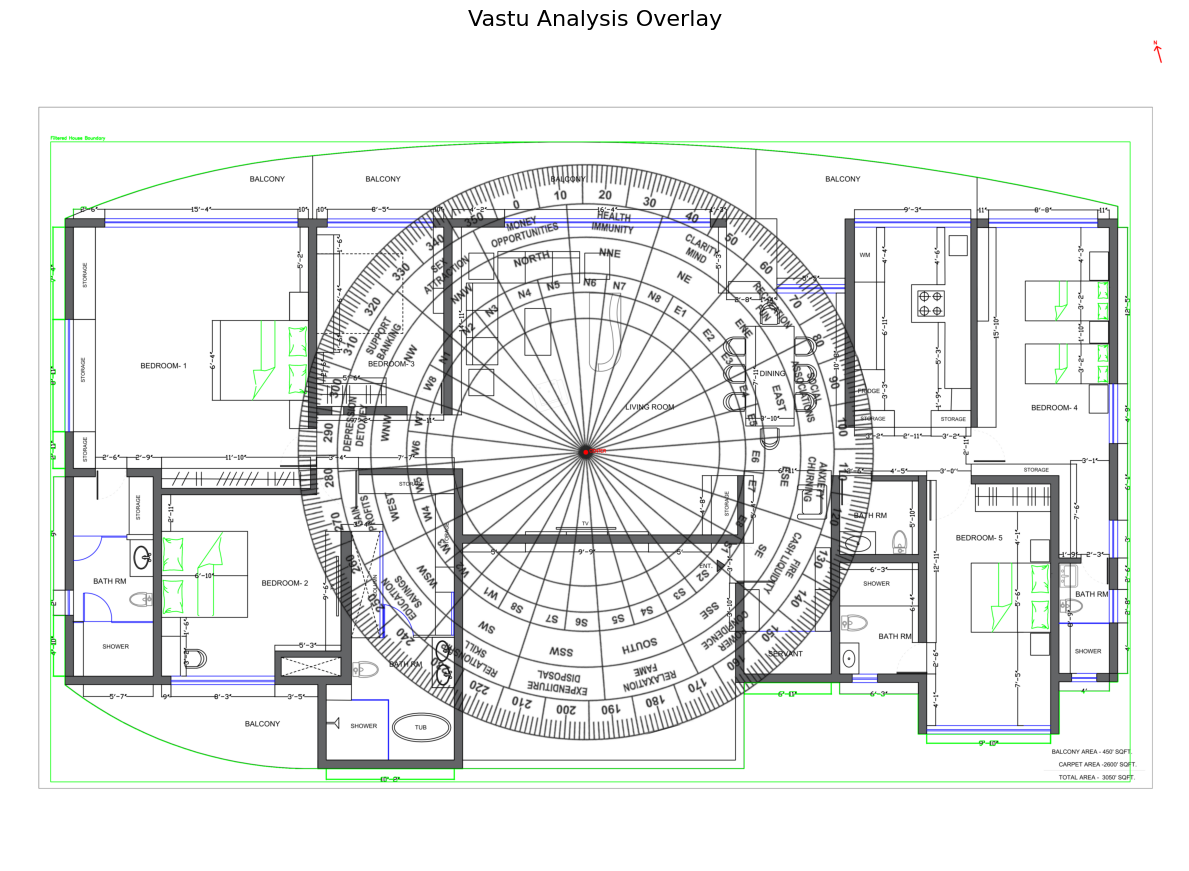

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform

def show_image(final_img, title="Image"):
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_blueprint(blueprint_path: str, center_lat: float, center_lon: float, point_lat: float, point_lon: float):

    def calculate_north_angle(center_lat: float, center_lon: float, point_lat: float, point_lon: float) -> float:
        """Calculates the angle of true North based on two geographic points."""
        in_proj = Proj('epsg:4326')  # WGS84
        out_proj = Proj('epsg:3857') # Web Mercator

        center_x, center_y = transform(in_proj, out_proj, center_lon, center_lat, always_xy=True)
        point_x, point_y = transform(in_proj, out_proj, point_lon, point_lat, always_xy=True)

        delta_x = point_x - center_x
        delta_y = point_y - center_y
        angle_rad = np.arctan2(delta_y, delta_x)
        angle_deg = np.degrees(angle_rad)

        rotation_angle = 90 - angle_deg
        return rotation_angle

    def overlay_image(base_img, overlay_img, centroid, structure_w, structure_h, rotation_angle: float = 0.0, relative_scale: float = 0.9, opacity: float = 0.85):
        """Overlays the chakra image, applying rotation and scaling."""
        if overlay_img is None:
            print("⚠️ Overlay image not found. Skipping overlay.")
            return base_img
            
        if overlay_img.shape[2] != 4:
            raise ValueError("Overlay image must be a 4-channel BGRA image.")

        chakra_h_orig, chakra_w_orig = overlay_img.shape[:2]

        # Aspect ratio of original image
        aspect_ratio = chakra_w_orig / chakra_h_orig

        # Desired max dimensions
        max_w = int(structure_w * relative_scale)
        max_h = int(structure_h * relative_scale)

        # Scale based on whichever is smaller ratio
        if (max_w / aspect_ratio) <= max_h:
            # Width is the limiting factor
            new_w = max_w
            new_h = int(max_w / aspect_ratio)
        else:
            # Height is the limiting factor
            new_h = max_h
            new_w = int(max_h * aspect_ratio)


        if new_w <= 0 or new_h <= 0:
            print("⚠️ Calculated overlay size is zero. Skipping overlay.")
            return base_img
            
        chakra_resized = cv2.resize(overlay_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        h, w = chakra_resized.shape[:2]
        center_rot = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center_rot, -rotation_angle, 1.0)
        
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        new_w_rot = int((h * sin) + (w * cos))
        new_h_rot = int((h * cos) + (w * sin))

        M[0, 2] += (new_w_rot / 2) - center_rot[0]
        M[1, 2] += (new_h_rot / 2) - center_rot[1]

        rotated_chakra = cv2.warpAffine(chakra_resized, M, (new_w_rot, new_h_rot))
        rotated_chakra[:, :, 3] = (rotated_chakra[:, :, 3] * np.clip(opacity, 0.0, 1.0)).astype(np.uint8)

        cx, cy = centroid
        h_chakra, w_chakra = rotated_chakra.shape[:2]
        x_offset = cx - w_chakra // 2
        y_offset = cy - h_chakra // 2

        h_final, w_final = base_img.shape[:2]
        x1_roi, x2_roi = max(0, x_offset), min(w_final, x_offset + w_chakra)
        y1_roi, y2_roi = max(0, y_offset), min(h_final, y_offset + h_chakra)

        x1_chakra = max(0, -x_offset)
        y1_chakra = max(0, -y_offset)
        x2_chakra = x1_chakra + (x2_roi - x1_roi)
        y2_chakra = y1_chakra + (y2_roi - y1_roi)

        roi = base_img[y1_roi:y2_roi, x1_roi:x2_roi]
        chakra_crop = rotated_chakra[y1_chakra:y2_chakra, x1_chakra:x2_chakra]

        if chakra_crop.shape[0] == 0 or chakra_crop.shape[1] == 0:
            return base_img

        alpha = chakra_crop[:, :, 3:4] / 255.0
        bgr_chakra = chakra_crop[:, :, :3]

        blended_roi = (alpha * bgr_chakra) + ((1 - alpha) * roi)
        base_img[y1_roi:y2_roi, x1_roi:x2_roi] = blended_roi.astype(np.uint8)
        return base_img

    def draw_annotations(image, centroid, contour, bbox, rotation_angle: float):
        """Draws all annotations on the final image."""
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, "Filtered House Boundary", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        if centroid:
            cv2.circle(image, centroid, 10, (0, 0, 255), -1)
            cv2.putText(image, "CENTER", (centroid[0] + 15, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        img_h, img_w = image.shape[:2]
        
        arrow_base_x = img_w - 80
        arrow_base_y = 120
        arrow_length = 70
        
        angle_rad = np.radians(rotation_angle)
        
        cos_val = np.cos(angle_rad)
        sin_val = np.sin(angle_rad)
        
        tip_x_offset = arrow_length * sin_val
        tip_y_offset = -arrow_length * cos_val
        
        arrow_tip_x = int(arrow_base_x + tip_x_offset)
        arrow_tip_y = int(arrow_base_y + tip_y_offset)
        
        cv2.arrowedLine(image, (arrow_base_x, arrow_base_y), (arrow_tip_x, arrow_tip_y), (0, 0, 255), 3, tipLength=0.3)
        
        text_x = int(arrow_tip_x + tip_x_offset * 0.2) 
        text_y = int(arrow_tip_y + tip_y_offset * 0.2)
        cv2.putText(image, "N", (text_x-10, text_y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return image

    # --- Main Script ---

    # Step 1: Load images
    try:
        img = cv2.imread(blueprint_path, cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread('shakti_chakra.png', cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError("Could not read the main image ('utsavhome.png'). Please check the file path.")
    except FileNotFoundError as e:
        print(e)
        exit()

    output_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Threshold to binary
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Step 3: Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 4: Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)

    # Step 5: Find the biggest non-background component
    max_area = 0
    max_label = -1
    if num_labels > 1:
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            aspect_ratio = max(w, h) / (min(w, h) + 1e-6) # Add epsilon to avoid division by zero
            if area > max_area and aspect_ratio < 4:
                max_area = area
                max_label = i

    # Step 6: Process the largest component if found
    if max_label != -1:
        house_mask = np.zeros_like(binary)
        house_mask[labels == max_label] = 255

        # Step 7: Find contours of the main house
        contours, _ = cv2.findContours(house_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            main_contour = max(contours, key=cv2.contourArea)
            
            # Get the centroid
            M = cv2.moments(main_contour)
            if M["m00"] == 0:
                raise ValueError("Cannot find centroid — zero area detected.")
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            center = (cx, cy)
            
            # Get bounding box for scaling
            x, y, w, h = cv2.boundingRect(main_contour)
            bbox = (x, y, w, h)

            # south lendmark
            CENTER_LAT = center_lat 
            CENTER_LON = center_lon

            # main loaction
            POINT_LAT = point_lat
            POINT_LON = point_lon


            
            print("Calculating North angle from geographic coordinates...")
            angle = calculate_north_angle(CENTER_LAT, CENTER_LON, POINT_LAT, POINT_LON)
            print(f"Calculated rotation angle: {angle:.2f} degrees")
            
            # Overlay the second image
            output_img = overlay_image(output_img, img2, center, w,h, rotation_angle=angle)
            
            # Draw all annotations
            output_img = draw_annotations(output_img, center, main_contour, bbox, angle)
            return output_img
            
        else:
            print("No contour found after filtering for the largest component.")
    else:
        print("No suitable component found for the house structure.")

# path_image = '12.png'
path_image = './TEST_IMAGE/VEERA_HT.png'
output_img = process_blueprint(path_image, 19.02616731837857, 72.85191449640524, 19.027050243177616, 72.85165187761763)
show_image(output_img, "Vastu Analysis Overlay")